In [2]:

from attorch.dataset import ListDataset
from blinkende_lichter.datatools import RandomFlip, TypeConversion 
from torchvision import transforms 
from torch.utils.data import DataLoader 
import numpy as np 
import torch

from PIL import Image
from argparse import ArgumentParser

from torch.optim import Adam
from torch.autograd import Variable

from blinkende_lichter.unet.network import UNet
from blinkende_lichter.unet.criterion import CrossEntropyLoss2d

from random import randint
import matplotlib.pyplot as plt
import random

In [3]:
transform = transforms.Compose([    
    RandomFlip(),    
    TypeConversion(np.float32, np.long) ]) 
dat = np.load('../datasets/data_interpolated.npz')

tr = dat['train']
vd = dat['validation']
for image in tr[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
    

for image in vd[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
               


            
            
train = ListDataset(*tr, transform=transform)

val = ListDataset(*vd) 
trainloader = DataLoader( train, shuffle=True, batch_size=1) 
for x, y in trainloader:
    print(x.size(), y.size())
images, labels = next(iter(trainloader))


torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])


In [60]:
MAX_CHECKS = 10
best_score = 1000
checks = 0
NUM_CHANNELS = 2
NUM_CLASSES = 2


Net = UNet
model = Net(NUM_CLASSES)
model = model.cuda()
#model.load_state_dict(torch.load("model_data"))



        
    
        


In [ ]:

def evaluate(Net, test_values, loss_graph):
    Net.eval()
    global best_score, checks, MAX_CHECKS
    for i in range(len(test_values.data[0])):
        input = torch.FloatTensor(test_values.data[0][i]).cuda()
        target = Variable(torch.from_numpy(test_values.data[1][i])).cuda()
        output = Net(Variable(input).unsqueeze(0))
        val_loss = criterion(output, target.unsqueeze(0))
        
        score = val_loss.data[0]
        
        if score <= best_score:
            best_score = score
            checks = 0
        else:
            checks+=1
        loss_graph.append((score))
        if (checks>=MAX_CHECKS):
            print("Breaking")
            break

        


In [72]:
model.train()
weight = torch.ones(NUM_CLASSES)
weight[0] = 0
patience = 1000
criterion = CrossEntropyLoss2d()
optimizer = Adam(model.parameters())
epoch_loss = []
val_epoch_loss = []
train_inputs = []
train_targets = []
train_outputs = []
test_inputs = []
test_targets = []
test_outputs = []
for epoch in range(1, 1001):
    for step, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda()
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_inputs.append(inputs.data.cpu().numpy())
        train_targets.append(targets.data.cpu().numpy())
        train_outputs.append(outputs.data.cpu().numpy())
        epoch_loss.append((loss.data[0]))
        

    model.eval()

    for i in range(len(val.data[0])):
        input = torch.FloatTensor(val.data[0][i]).cuda()
        target = Variable(torch.from_numpy(val.data[1][i])).cuda()
        output = model(Variable(input).unsqueeze(0))
        test_inputs.append(input.cpu().numpy())
        test_targets.append(target.data.cpu().numpy())
        test_outputs.append(output.data.cpu().numpy())
        val_loss = criterion(output, target.unsqueeze(0))
        val_epoch_loss.append(val_loss.data[0])
    
        if(epoch>=patience):
            if(len(val_epoch_loss) % 4 == 0):
                score = sum(val_epoch_loss[-4:])/len(val_epoch_loss[-4:])
                if score <= best_score:
                    best_score = score
                    checks = 0
                else:
                    checks+=1

                if (checks>=MAX_CHECKS):
                    break
                else:
                    continue                
                break
            else:
                continue
            break
        else:
            continue
        break
    else:
        continue
    break

torch.save(model.state_dict(), "model_data")

torch.save(epoch_loss, "loss")
torch.save(val_epoch_loss, "validation loss")

print("Training and evaluation complete.")

Training and evaluation complete.


In [11]:
%matplotlib inline


In [73]:
in_img = input.cpu().numpy()
in_img_avg = in_img[0]
in_img_corr = in_img[1]
tgt_img = target.data.cpu().numpy()
out_data = test_outputs[511]
indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_data*indicator, axis=1)
x = np.exp(out_data)
res = x/x.sum(1)

pos = np.argmax(res, axis=1)


In [74]:
out_mod = []

for n in range(len(test_outputs)):
    out_data = test_outputs[n]
    indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
    np.sum(out_data*indicator, axis=1)
    x = np.exp(out_data)
    res = x/x.sum(1)
    pos = np.argmax(res, axis=1)
    out_mod.append(pos.squeeze())

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
plt.figure()

plt.subplots(figsize=(12,12))

avg = plt.subplot(221)
corr = plt.subplot(222)
tgt = plt.subplot(223)
out = plt.subplot(224)

avg.title.set_text("Average Image")
corr.title.set_text("Correlation Image")
tgt.title.set_text("Target Image")
out.title.set_text("Output Image")

avg.imshow(in_img_avg)
corr.imshow(in_img_corr)
tgt.imshow(tgt_img)
out.imshow(pos.squeeze())



plt.tight_layout()

In [ ]:
dat['train'][1][0]

In [ ]:
np.unique(target.cpu().numpy())

In [ ]:
label = vd
fig = plt.figure(figsize=(12,12))
plt.imshow(label)
plt.colorbar()

In [75]:
epoch

1000

In [ ]:
plt.figure()
fig, ax = plt.subplots(nrows=4,ncols=3, figsize=(12,12))
ax[0][0].title.set_text("Target")
ax[0][1].title.set_text("Output")
ax[0][2].title.set_text("Overlap")
overlaps = []
for i in range(len(tt_mod)):
    ax[i][0].imshow(tt_mod[i])
    
for j in range(len(to_mod)):
    ax[j][1].imshow(to_mod[j])
    
for k in range(len(to_mod)):
    image = to_mod[k]
    ol = np.zeros((len(image),len(image), 3))
    for h in range(len(image)):
        for w in range(len(image)):
            ol[w][h][0]=test_targets[k][w][h]
            ol[w][h][1]=image[w][h]
    overlaps.append(ol)

for o in range(len(overlaps)):
    ax[o][2].imshow(overlaps[o])
    

plt.tight_layout


In [ ]:

train_in = []
train_tgt = []
train_out = []
for i in range(4):
    r = randint(0,14)
    train_in.append(torch.FloatTensor(tr[0][r].astype(float)).cuda())
    train_tgt.append(torch.from_numpy(tr[1][r]).long())
    

In [ ]:
type(tr)

In [ ]:
model.eval()
for i in range(len(train_in)):
    out = model(Variable(train_in[i]).unsqueeze(0))
    train_out.append(out)

In [ ]:
train_out[3]

In [ ]:
plt.figure()
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
ax[0][0].title.set_text("Target")
ax[0][1].title.set_text("Output")


for i in range(len(train_tgt)):
    ax[i][0].imshow(train_tgt[i].numpy())
    ax[i][1].imshow(train_out_mod[i])

plt.tight_layout

In [ ]:
train_out_mod = []
for n in range(len(train_out)):
    out_data = train_out[n].data.cpu().numpy()
    indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
    np.sum(out_data*indicator, axis=1)
    x = np.exp(out_data)
    res = x/x.sum(1)
    pos = np.argmax(res, axis=1)
    train_out_mod.append(pos.squeeze())

In [ ]:
targets.max()

In [ ]:
train_tgt

In [ ]:
model

In [ ]:
train_out_mod[1]

In [ ]:
range(5)

In [ ]:
plt.imshow(train_out_mod[0])

In [ ]:
fig = plt.figure(figsize=(12,12))
tgt = plt.subplot(221)
op = plt.subplot(222)
tgt.title.set_text("Target Image")
op.title.set_text("Output Image")
tgt.imshow(train_tgt[0].numpy())
op.imshow(train_out_mod[0])


In [ ]:
test_outputs

In [ ]:
type(val)

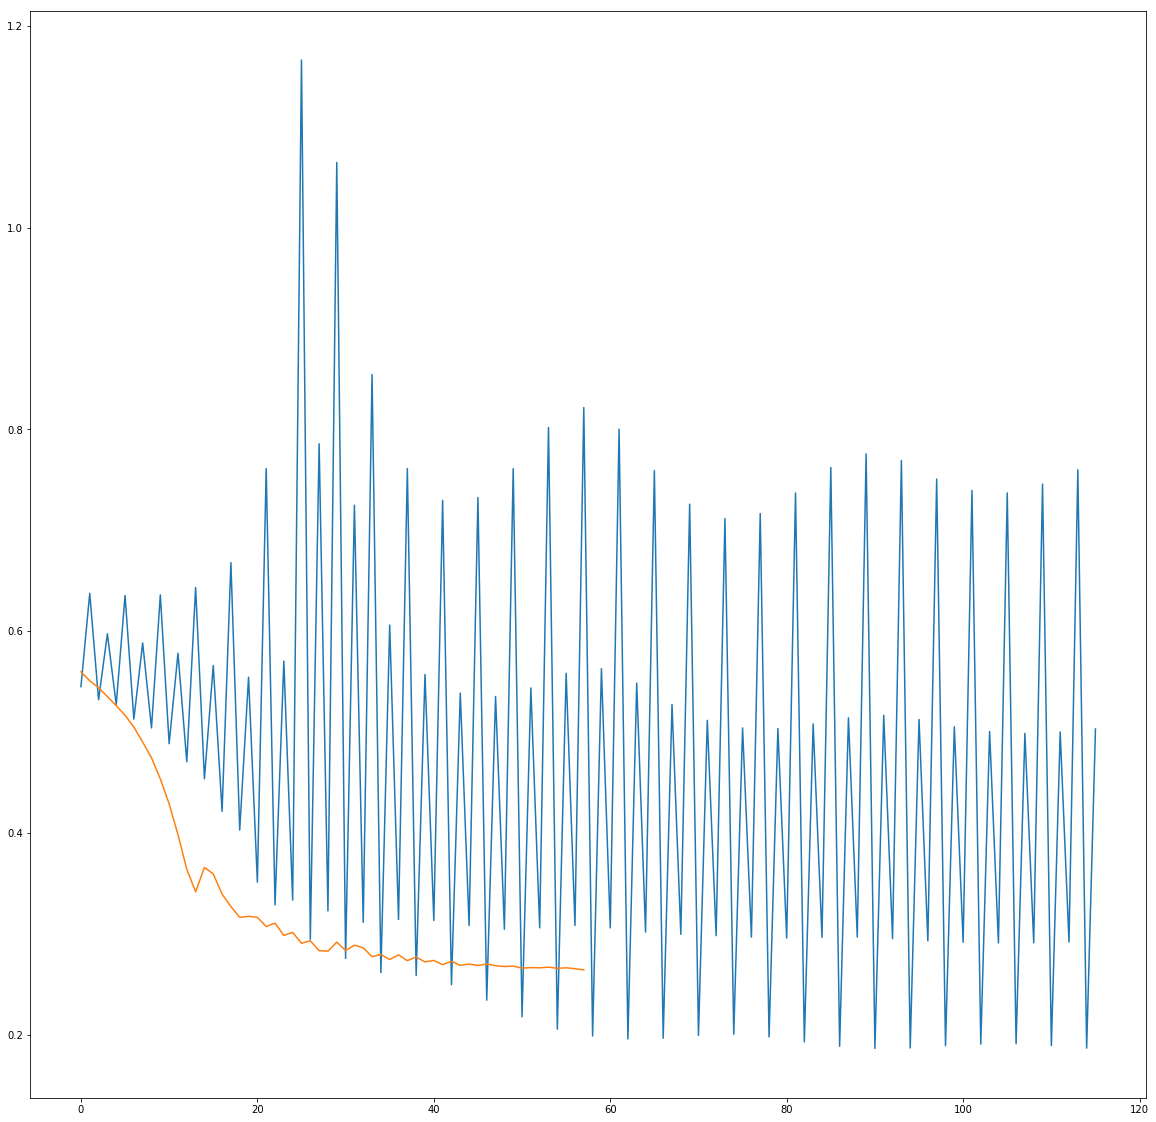

In [63]:
fig = plt.figure(figsize=(20,20))
plt.plot(val_epoch_loss)
plt.plot(epoch_loss)

plt.show()

In [ ]:
len(latest_loss)

In [ ]:
checks

In [ ]:
latest_val_loss

In [ ]:
enumerate(val_epoch_loss)

In [81]:
avg_ep = [epoch_loss[x:x+2] for x in range(0, len(epoch_loss), 2)]
avg_val_ep = [val_epoch_loss[x:x+4] for x in range(0, len(val_epoch_loss), 4)]


for i in range(len(avg_ep)):
    avg_ep[i]=sum(avg_ep[i])/len(avg_ep[i])

for i in range(len(avg_val_ep)):
    avg_val_ep[i]=sum(avg_val_ep[i])/len(avg_val_ep[i])

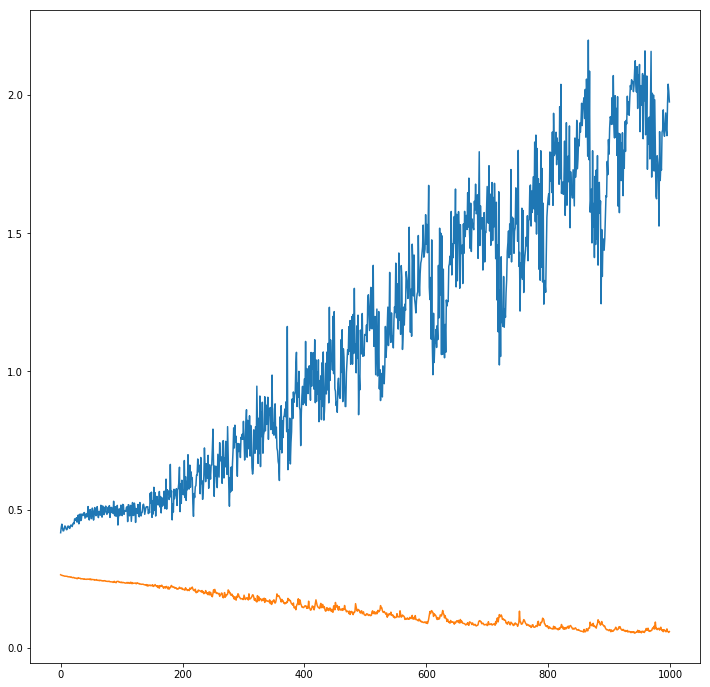

In [82]:
fig = plt.figure(figsize=(12, 12))
plt.plot(avg_val_ep)
plt.plot(avg_ep)


In [83]:
best_score

0.4112931340932846

In [ ]:
for param in model.parameters():
    print(param.data, param.size())

In [ ]:
plt.show()

In [ ]:
len(test_inputs[36:])

In [ ]:
ti_mod

In [ ]:
out_mod

In [ ]:
out_mod[36:]

In [ ]:
to_mod[0].max()

In [ ]:
plt.imshow(pos.squeeze())

In [ ]:
pos.squeeze()

In [ ]:
range(0, len(val_epoch_loss),4)

In [ ]:
val_epoch_loss[0:4]

In [ ]:
f =[1,2,3,4]

In [ ]:
len(f)%4

In [ ]:
len(val_epoch_loss)

In [ ]:
epoch

In [ ]:
score

In [ ]:
if (len(f) % 4 == 0):
    temp = f[-4:]

In [ ]:
temp

In [ ]:
sum(temp)/len(temp)

In [ ]:
sum(val_epoch_loss[-4:])/4

In [ ]:
epoch

In [ ]:
len(test_outputs)

In [ ]:
552/4

In [ ]:
epoch

In [80]:
best_score

0.4112931340932846

In [ ]:
min(avg_val_ep)

In [ ]:
test_outputs[38]

In [ ]:
out_data = test_outputs[511]
indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_data*indicator, axis=1)
x = np.exp(out_data)
res = x/x.sum(1)

pos = np.argmax(res, axis=1)

In [ ]:
fig = plt.figure(figsize=(12,12))
%matplotlib inline
plt.imshow(pos.squeeze())

In [ ]:
len(val_epoch_loss)

In [ ]:
len(test_outputs)

In [ ]:
sum(val_epoch_loss[508:512])/4

In [44]:
checks

988

In [ ]:
len(input)

In [66]:
train_outputs[-1]

array([[[[-0.17320722, -0.16692537, -0.15515012, ..., -0.08833408,
          -0.09967005, -0.10585964],
         [-0.17089278, -0.16525298, -0.15324658, ..., -0.08479905,
          -0.09687936, -0.1046356 ],
         [-0.17446762, -0.16857922, -0.15738446, ..., -0.08257961,
          -0.09704328, -0.10584259],
         ..., 
         [-0.16681367, -0.16241783, -0.16742021, ..., -0.1135242 ,
          -0.12321949, -0.12572622],
         [-0.16524851, -0.16095161, -0.16614312, ..., -0.11745191,
          -0.12743104, -0.12841988],
         [-0.16278648, -0.15776062, -0.16312712, ..., -0.11837041,
          -0.12629282, -0.12807679]],

        [[-1.83861983, -1.87250996, -1.93993425, ..., -2.47047138,
          -2.35531139, -2.29810429],
         [-1.85094833, -1.88176644, -1.95135212, ..., -2.50956964,
          -2.38233662, -2.30913305],
         [-1.83198166, -1.8634553 , -1.92672443, ..., -2.53499866,
          -2.38072729, -2.2982564 ],
         ..., 
         [-1.87312603, -1.897692

In [76]:
test = train_outputs[-1]

In [77]:
indicator  =  np.arange(test.shape[1]).reshape([1, -1, 1, 1])
np.sum(test*indicator, axis=1)
x = np.exp(test)
res = x/x.sum(1)
pos = np.argmax(res, axis=1)

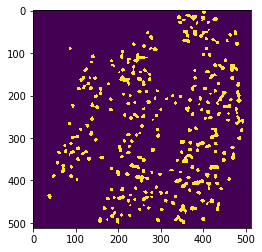

In [78]:
plt.imshow(pos.squeeze())

In [79]:
checks

11

[array([[[[-0.75205517, -0.75683892, -0.75724769, ..., -0.75788873,
           -0.74141234, -0.7170527 ],
          [-0.75210923, -0.75597203, -0.75777781, ..., -0.75681436,
           -0.74143416, -0.71707559],
          [-0.75288486, -0.75643569, -0.75714546, ..., -0.7572608 ,
           -0.74166113, -0.7178669 ],
          ..., 
          [-0.71977574, -0.71830839, -0.72299725, ..., -0.76087552,
           -0.74439889, -0.72092837],
          [-0.72166538, -0.72145045, -0.72425222, ..., -0.75685847,
           -0.74053138, -0.71722841],
          [-0.71917629, -0.71997482, -0.72267681, ..., -0.75190705,
           -0.73705089, -0.71248734]],
 
         [[-0.63751709, -0.63327026, -0.63290918, ..., -0.63234341,
           -0.64710474, -0.66979986],
          [-0.63746893, -0.63403696, -0.63244116, ..., -0.63329202,
           -0.64708483, -0.66977787],
          [-0.63677776, -0.63362676, -0.63299942, ..., -0.63289762,
           -0.6468783 , -0.66902369],
          ..., 
          [

In [52]:
from contextlib import contextmanager
@contextmanager
def nested_break():
    class NestedBreakException(BaseException):
        pass
    try:
        yield NestedBreakException
    except NestedBreakException:
        pass

In [54]:
test_outputs

[array([[[[-0.07330984, -0.08687502, -0.09521592, ..., -0.13784581,
           -0.12522435, -0.09658122],
          [-0.08506334, -0.10236865, -0.11242813, ..., -0.14689571,
           -0.13093716, -0.09900796],
          [-0.09083235, -0.11058623, -0.12052023, ..., -0.15298766,
           -0.13378686, -0.10007727],
          ..., 
          [-0.03972232, -0.0413698 , -0.04210913, ..., -0.14794207,
           -0.12658978, -0.09432387],
          [-0.03541613, -0.0369935 , -0.0383389 , ..., -0.13673866,
           -0.11605984, -0.08634275],
          [-0.03134334, -0.03240573, -0.03450835, ..., -0.12523437,
           -0.10534906, -0.07706118]],
 
         [[-2.64949179, -2.48640728, -2.398839  , ..., -2.04975128,
           -2.13960743, -2.38527274],
          [-2.50658941, -2.32992268, -2.24112868, ..., -1.99058104,
           -2.09779263, -2.36165047],
          [-2.44381189, -2.25674391, -2.17559195, ..., -1.95291674,
           -2.07765532, -2.35143423],
          ..., 
          [

In [55]:
best_score

0.4345455691218376